# **Approche non supervisée**

In [1]:
import pandas as pd

import matplotlib.pyplot as plt

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.models import Nmf
from gensim.models import TfidfModel


#vis
import pyLDAvis
import pyLDAvis.gensim

# Mesures de durée d'éxécution
import time

# Éviter les Deprecation Warning avec NMF
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Utilisé lors des sauvagardes et chargement de données/objets
import pickle
import os

- Mesure de la durée d'exécution du notebook : 

In [2]:
t_notebook = time.time()

## **Importations des données**

In [3]:
with open('data_clean.pkl', 'rb') as fichier:
    data = pickle.load(fichier)

data

,corpus,tags
0,"[firebase, testing, jest, error, assertion, cl...","[jestjs, firebase, reactjs]"
1,"[block, hack, language, benefit, block, job, w...","[async-await, concurrency]"
2,"[type, function, typescript, function, type, i...",[typescript]
3,"[store, service, account, looking, expo, appli...",[expo]
4,"[store, retrieve, structure, type, c, copying,...",[c]
...,...,...
46493,"[option, option, know, option, case, option, o...","[javascript, jquery]"
46494,"[ring, plot, attempt, gap, use, plot, paint, r...","[matplotlib, python]"
46495,"[security, problem, terraform, dependency, loc...",[terraform]
46496,"[studio, creation, blob, container, error, mes...",[azure]


## **Option d'échantillonages pour la réalisation de tests**

In [4]:
echantillon = True
taille_echantillon = 5000

if echantillon:
    data = data.sample(taille_echantillon, random_state=42)  # random_state car en fonction de l'échantillonage
                                                             # les résultats peuvent changer et pour pouvoir
                                                             # comparer nos tunings d'hyperparamètres, nous devons
                                                             # avoir des résultats reproductibles

data

,corpus,tags
564,"[canvas, context, hundred, thousand, image, pu...","[javascript, performance, typescript]"
501,"[path, mapping, javascript, javascript, projec...","[javascript, typescript]"
11879,"[ide, code, style, variable, studio, project, ...",[c#]
20868,"[column, name, pyspark, alias, dataframe, alia...","[dataframe, pyspark, python]"
18585,"[border, swift, question, solution, problem, b...",[swift]
...,...,...
39242,"[index, range, exception, null, function, exce...",[powershell]
33953,"[swiftui, gesture, control, camera, model, dis...","[swiftui, swift]"
2830,"[localstorage, react, callback, typescript, ho...","[typescript, react-hooks, reactjs]"
21726,"[code, folder, give, error]",[python]


## **Vectorisation du corpus**

In [5]:
# Création d'un dictionnaire avec le vocabulaire de notre corpus
id2word = corpora.Dictionary(data['corpus'])

# Vocabulaire présent dans le corpus
print(f"Taille du dictionnaire (donc du vocabulaire de notre corpus) : {len(id2word)}")

# Création d'un corpus encodé en bag of word (bow) classique
corpus = []
for text in data['corpus']:
    new = id2word.doc2bow(text)
    corpus.append(new)


# Création d'un corpus encodé en bag of word (bow) TF-IDF
tfid_model = TfidfModel(corpus)  # On reprend le bow classique et en entraîne TfidfModel()
tfid_corpus = tfid_model[corpus]  # Création du corpus encodé en bow TF-IDF


print("-"*50)

# Pour exemple, les 20 premiers mots (encodé en bow) du premier document de notre corpus
print(f"Premier document encodé (BoW classique): {corpus[0][0:20]}")
print(f"Premier document encodé (BoW TF-IDF): {tfid_corpus[0][0:20]}")

Taille du dictionnaire (donc du vocabulaire de notre corpus) : 3367
--------------------------------------------------
Premier document encodé (BoW classique): [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 9), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 5), (14, 2), (15, 3), (16, 1), (17, 1), (18, 1), (19, 1)]
Premier document encodé (BoW TF-IDF): [(0, 0.03971473955616458), (1, 0.018770994749701782), (2, 0.02363233721395688), (3, 0.027082241977563346), (4, 0.015786145263364866), (5, 0.03971473955616458), (6, 0.3005864169017757), (7, 0.013090675008738395), (8, 0.037012548906368285), (9, 0.006440619316462042), (10, 0.033795151304430074), (11, 0.034221220077027686), (12, 0.03468140940919713), (13, 0.10769896006167284), (14, 0.06759030260886015), (15, 0.11599955610397976), (16, 0.03633537920415542), (17, 0.034221220077027686), (18, 0.028207635768473658), (19, 0.035729630264035125)]


## **Premier modèle : LDA (Latent Dirichlet Allocation)**

### **A). Avec corpus en BoW classique**

- Tests pour déterminer le nombre de sujets qui apporte le meilleur score de cohérence (CV) : 

<div class="alert alert-info">
Le score de cohérence 'c_v' est un nombre réel qui mesure à quel point les mots à l'intérieur de chaque topic sont similaires les uns aux autres en termes de co-occurrence dans les documents. Un score de cohérence plus élevé indique des topics plus cohérents, c'est-à-dire que les mots à l'intérieur d'un topic ont tendance à apparaître ensemble dans les documents. Il permet d'évaluer la qualité d'un modèle de topic modeling (ici LDA). Plus le score de cohérence est élevé, meilleure est la cohérence des topics.
</div>

In [6]:
# Les tests étant très longs, ne les lançons pas à chaque exécution du notebook
do_test = False

if do_test:

    tests_results_lda = {}

    for i in range(0, 201, 5):  # Il n'est pas pertinent de tester au delà de 200 topics
                                # puisque nous avons précédemment restreint le nombre de tags uniques à 200

        num_topics_lda = i

        # Il faut au moins un sujet
        if i == 0:
            num_topics_lda = i + 1

        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=num_topics_lda,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha="auto")
        
        coherence_model = CoherenceModel(model=lda_model, texts=data['corpus'], dictionary=id2word, coherence='c_v')

        coherence_score = coherence_model.get_coherence()

        tests_results_lda[lda_model.num_topics] = coherence_score

        print(f"{lda_model.num_topics} topics : {coherence_score:.4f}")

    nom_fichier = 'num_topics_lda'
    # Export du dataset data
    if os.path.isfile(f'{nom_fichier}.pkl') == False:
        with open(f'{nom_fichier}.pkl', 'wb') as fichier:
            pickle.dump(tests_results_lda, fichier)
        print(f"Fichier {nom_fichier}.pkl créé.")
    else:
        print(f"Le fichier {nom_fichier}.pkl existe déjà, si vous souhaitez en exporter une nouvelle version, supprimez l'ancien.")

- Résultats : 

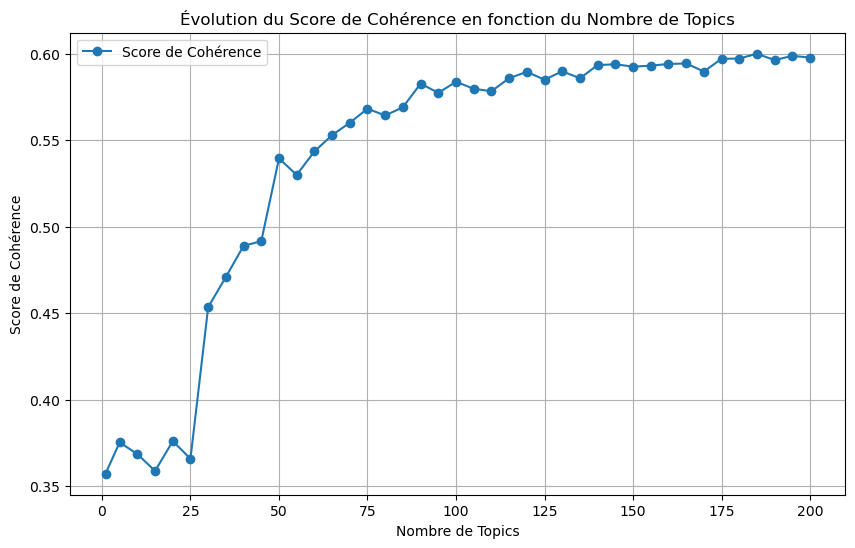

In [7]:
# Chargement des données provenant des tests réalisés (sur échantillon de 5000): 
with open('num_topics_lda.pkl', 'rb') as fichier:
    tests_results = pickle.load(fichier)

# Réprésentation graphique des résultats : 

num_topics = list(tests_results.keys())
coherence_scores = list(tests_results.values())

# Créer un graphique à l'aide de matplotlib
plt.figure(figsize=(10, 6))  # Définir la taille du graphique (facultatif)

# Tracer la courbe des scores de cohérence
plt.plot(num_topics, coherence_scores, marker='o', linestyle='-')

# Ajouter des étiquettes et un titre
plt.xlabel('Nombre de Topics')
plt.ylabel('Score de Cohérence')
plt.title('Évolution du Score de Cohérence en fonction du Nombre de Topics')

# Afficher la légende (facultatif)
plt.legend(['Score de Cohérence'])

# Afficher le graphique
plt.grid(True)  # Activer la grille (facultatif)
plt.show()

<div class="alert alert-info">
Le score de cohérence CV n'est qu'un indicateur parmi d'autres. Il ne doit pas être le seul critèque de choix. Le contexte métier est important ici : nous avons 200 tags uniques, le nombre de sujets à déterminer doit donc être assez important. Choisir par exemple de ne dégager que 10 sujets de tout notre corpus, alors que l'on tente de prédire 200 tags, ne serait pas pertinent.<br><br>
Nous devons également considérer le nombre de topics qui produiront les meilleurs résultats dans nos deux approches de proposition de tags qui vont suivre.<br><br>
Nous devons enfin garder en tête que l'augmentation du nombre de topics peut augmenter significativement les durées d'entraînement des modèles.
</div>

- Entraînement du modèle LDA avec un nombre de topics optimal (contexte métier, résultats pour nos deux approches et scores de cohérence à titre indicatif et de comparaison) : 

In [8]:
# On choisit un nombre de topics parmis ceux avec les meilleurs scores de cohérence
num_topics_lda = 100

debut = time.time()  # Heure de début du traitement

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics_lda,
                                           random_state=100,
                                           update_every=1, # 1
                                           chunksize=2000, # 100
                                           passes=5,  # 10
                                           alpha="auto", # "auto"
                                           eta='auto',
                                           iterations=10, # 50
                                           decay=0.6, # 0.5
                                           offset=1, # 1
                                           gamma_threshold=0.001, # 0.001
                                           minimum_probability=0.01 # 0.01
                                           )

print(f"Durée du traitement : {(time.time() - debut):.2f} s")

Durée du traitement : 10.07 s


- Calcul du score de cohérence de ce modèle : 

In [9]:
debut = time.time()  # Heure de début du traitement

coherence_model = CoherenceModel(model=lda_model, texts=data['corpus'], dictionary=id2word, coherence='c_v')

coherence_score = coherence_model.get_coherence()

print(f"Durée du traitement : {(time.time() - debut):.2f} s")

print(f"Score de cohérence avec {lda_model.num_topics} topics : {coherence_score:.4f}")

Durée du traitement : 14.20 s
Score de cohérence avec 100 topics : 0.3838


- Affichage des topics trouvés avec ce modèle : 

*num_words* pour choisir le nombre de mot à afficher pour chaque topic<br>
À chaque mot est associé un nombre : son importance pour le topic en question.


In [10]:
# Nombre de mots à afficher pour chaque topics
num_words = 10

topics_lda = lda_model.show_topics(num_topics=lda_model.num_topics, num_words=num_words)

for topic in topics_lda[:10]: # 10 premiers seulement
    print(topic)

(0, '0.244*"thread" + 0.060*"declaration" + 0.049*"worker" + 0.028*"compilation" + 0.027*"time" + 0.026*"function" + 0.025*"question" + 0.025*"process" + 0.021*"increment" + 0.021*"code"')
(1, '0.149*"operator" + 0.095*"mongodb" + 0.083*"download" + 0.062*"socket" + 0.055*"connect" + 0.041*"pipe" + 0.041*"cassandra" + 0.031*"operand" + 0.029*"error" + 0.027*"adapter"')
(2, '0.110*"expression" + 0.068*"constraint" + 0.063*"understand" + 0.059*"behaviour" + 0.059*"trigger" + 0.043*"case" + 0.042*"track" + 0.036*"error" + 0.028*"code" + 0.026*"complexity"')
(3, '0.108*"scenario" + 0.104*"role" + 0.091*"log" + 0.080*"aw" + 0.058*"policy" + 0.042*"lambda" + 0.035*"progress" + 0.035*"force" + 0.034*"ref" + 0.026*"console"')
(4, '0.416*"name" + 0.076*"pipeline" + 0.035*"agent" + 0.029*"execution" + 0.024*"error" + 0.022*"usage" + 0.021*"self" + 0.020*"pool" + 0.020*"code" + 0.020*"trying"')
(5, '0.162*"spring" + 0.099*"application" + 0.064*"boot" + 0.038*"configuration" + 0.037*"person" + 0.0

### **Définitions de nos fonctions**

- Fonction pour calculer les cas où il y a au moins un tag en commun entre tags réels et tags prédits : 

In [11]:
def predict_quality(predict, real):

    """
    Cette fonction permet de calculer le pourcentage de documents
    pour lesquels il y a au moins un tag en commun entre les
    tags prédits et les tags réels.
    -------------------
    predict : les tags prédits (sous forme de liste de liste, ou array de liste)
    real : les tags réels (sous forme de liste de liste, ou array de liste)

    """

    # Variable qui sera incrémentée à chaque fois
    # qu'il y aura un mot en commun entre prédiction et réel
    common_word_count = 0

    for predict_tag, real_tag in zip(predict, real):

        # Je convertis en set pour pouvoir facilement comparer ensuite
        predict_tag = set(predict_tag)
        real_tag = set(real_tag)
        
        # 'predict & real' retourne un set contenant les valeurs communes
        # entre les deux s'il y en a. Sinon un set vide sera retourné
        if predict_tag & real_tag:
            common_word_count += 1

    # Calculer le pourcentage de cas où il y a au moins un mot en commun
    total_cases = len(real)  # Autrement dit, le nombre de documents
                             # en considérant qu'il y a des tags réels
                             # pour tous les documents
    percentage_common_word_cases = (common_word_count / total_cases) * 100

    print(f"Cas avec au moins un mot en commun entre les tags réels et les tags prédits : {percentage_common_word_cases:.2f}%")

- **Approche 1 :** Pour chaque document, on conserve les premiers mots (les plus probables) du topic le plus probablement associé au document : 

In [12]:
def approche1(model, premiers_mots, real_tags, show_ex=True):

    """
    Cette fonction permet de réaliser notre première approche : 
    Pour chaque document, on conserve les premiers mots (les plus probables)
    du topic le plus probablement associé au document.

    Puis on utilise la fonction predict_quality()
    pour évaluer la qualité des prédictions.

    --------------------------

    - model : modèle (LDA, NMF) à utiliser.
    - premiers_mots : combien de premiers mots du topic on souhaite conserver.
    - real_tags : les tags réels pour évaluer la qualité des prédictions.
    - show_ex : montrer les tags prédits pour les 10 premiers documents.

    """

    # Liste pour stocker les mots les plus probables pour chaque document
    top_words_per_document = []

    debut = time.time()  # Heure de début du traitement

    # Parcourir les documents du corpus
    for doc in corpus:
        
        # Obtenir les probabilités d'appartenance aux topics pour ce document
        doc_topics = model.get_document_topics(doc)
        
        # Trouver le sujet le plus probable pour ce document
        most_probable_topic = max(doc_topics, key=lambda x: x[1])[0]
        
        # Obtenir les premiers mots les plus probables du sujet le plus probable
        top_words = model.show_topic(most_probable_topic, topn=premiers_mots)
        
        # Liste temporaire pour stocker les mots pour le document en cours
        temp_list = []
        for i in range(premiers_mots):
            temp_list.append(top_words[i][0])

        top_words_per_document.append(temp_list)

    # 'top_words_per_document' contient maintenant les x (= 'premiers_mots')
    #  premiers mots les plus probables pour le sujet le plus probable de chaque document.

    print(f"Durée du traitement : {(time.time() - debut):.2f} s\n")

    # Évaluation
    predict_quality(top_words_per_document, real_tags)

    if show_ex:
        # Exemples
        print("\nPour les 10 premiers documents : ")
        display(top_words_per_document[:10])

- **Approche 2** : Pour chaque document, on conserve un nombre défini de mots (au maximum, si possible) qui sont à la fois présents dans le document d'origine et dans le topic le plus probablement associé au document.

In [13]:
def approche2(model, taille_topic, max_mots_communs, real_tags, show_ex=True):

    """
    Cette fonction permet de réaliser notre deuxième approche : 
    Pour chaque document, on conserve un nombre défini de mots (au maximum, si possible)
    qui sont à la fois présents dans le document d'origine
    et dans le topic le plus probablement associé au document.

    Puisque cette approche peut générer des listes vides (aucun mot en commun),
    le pourcentage de listes vides est calculé.

    Puis on utilise la fonction predict_quality()
    pour évaluer la qualité des prédictions.

    --------------------------

    - model : modèle (LDA, NMF) à utiliser.
    - taille_topic : nombre de mots les plus probables du topic
                     associé au document, parmi lesquels on va
                     chercher des mots communs ceux du texte du document.
    - max_mots_communs : combien de mots commun on cherche au maximum.
    - real_tags : les tags réels pour évaluer la qualité des prédictions.
    - show_ex : montrer les tags prédits pour les 10 premiers documents.

    """

    # Liste pour stocker les x (x = taille_topic) mots du sujet les plus probables
    # et qui sont également présents dans le texte du document
    top_words_in_document = []

    debut = time.time()  # Heure de début du traitement

    # Parcourir les documents du corpus
    for i, doc in enumerate(corpus):

        # Obtenir les probabilités d'appartenance aux topics pour ce document
        doc_topics = model.get_document_topics(doc)
        
        # Trouver le sujet le plus probable pour ce document
        most_probable_topic = max(doc_topics, key=lambda x: x[1])[0]
        
        # Obtenir les mots du sujet le plus probable
        # topn : les x (x = taille_topic) premiers mots du sujet (les plus probables)
        top_words = [word for word, _ in model.show_topic(most_probable_topic, topn=taille_topic)]
        
        # Conserver les x (x = taille_topic) premiers mots du sujet qui sont également présents dans le document
        words_in_document = [word for word in top_words if word in data['corpus'].iloc[i]]
            
        # Sélectionner jusqu'à 'max_mots_communs' mots du sujet présents dans le document
        selected_words = words_in_document[:max_mots_communs]
        
        top_words_in_document.append(selected_words)

    # 'top_words_in_document' contient maintenant, pour chaque document,
    # jusqu'à 'max_mots_communs' mots communs entre les 'taille_topic' premiers mots
    # du topic le plus probable pour le document et les mots présents dans le texte du document.

    print(f"Durée du traitement : {(time.time() - debut):.2f} s\n")

    # Puisque nous ne retenons que les cas avec des valeurs communes,
    # il est possible que dans certains cas nous n'ayons qu'une liste vide.
    # Calculons si cela arrive souvent : 
    empty_lists_count = sum(1 for words in top_words_in_document if not words)
    total_lists = len(top_words_in_document)
    percentage_empty_lists = (empty_lists_count / total_lists) * 100
    print(f"Pourcentage de listes vides : {percentage_empty_lists:.2f}%\n")

    # Évaluation
    predict_quality(top_words_in_document, real_tags)

    if show_ex:
        # Exemples
        print("\nPour les 10 premiers documents : ")
        display(top_words_in_document[:10])

### **Approche 1, avec les 5 premiers mots des topics**

In [14]:
approche1(lda_model,
          premiers_mots=5,
          real_tags=data['tags']
)

Durée du traitement : 7.92 s

Cas avec au moins un mot en commun entre les tags réels et les tags prédits : 8.00%

Pour les 10 premiers documents : 


[['difference', 'directory', 'performance', 'calculation', 'piece'],
 ['javascript', 'attribute', 'mapping', 'tree', 'resolve'],
 ['default', 'language', 'constructor', 'background', 'code'],
 ['column', 'value', 'datum', 'sum', 'panda'],
 ['expression', 'constraint', 'understand', 'behaviour', 'trigger'],
 ['container', 'docker', 'vector', 'sub', 'comparison'],
 ['input', 'instance', 'timestamp', 'time', 'websocket'],
 ['compiler', 'practice', 'optimization', 'activity', 'optimize'],
 ['row', 'frame', 'column', 'code', 'time'],
 ['version', 'package', 'error', 'project', 'dependency']]

### **Approche 2, avec 5 mots en commun avec le document (au maximum)**

In [15]:
approche2(lda_model,
          taille_topic=50,
          max_mots_communs=5,
          real_tags=data['tags']
)

Durée du traitement : 10.71 s

Pourcentage de listes vides : 0.02%

Cas avec au moins un mot en commun entre les tags réels et les tags prédits : 10.34%

Pour les 10 premiers documents : 


[['performance', 'piece', 'case', 'way', 'example'],
 ['javascript', 'mapping', 'feature'],
 ['code', 'notification', 'ide', 'activate', 'tool'],
 ['column', 'dataframe', 'way', 'pyspark', 'name'],
 ['constraint', 'code', 'question', 'time', 'problem'],
 ['container', 'docker', 'system', 'need', 'error'],
 ['instance', 'code', 'part', 'flag'],
 ['way', 'dict', 'suggestion', 'attribute'],
 ['row', 'code', 'number', 'problem'],
 ['version', 'error', 'project', 'dependency']]

### **Visualisation des résultats de la LDA avec pyLDAvis**

In [16]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds="mmds", R=30, n_jobs=1)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
81     0.031890  0.273690       1        1  2.864748
14    -0.393360  0.137384       2        1  2.715774
22     0.271072  0.068161       3        1  2.549147
46    -0.079316 -0.297129       4        1  1.918702
20     0.055728 -0.257924       5        1  1.866967
...         ...       ...     ...      ...       ...
61     0.257438  0.260645      96        1  0.541426
70     0.408832  0.064883      97        1  0.500631
78    -0.152345  0.391783      98        1  0.494346
1     -0.138801 -0.096639      99        1  0.473486
8     -0.046076  0.476678     100        1  0.412152

[100 rows x 5 columns], topic_info=         Term         Freq        Total  Category  logprob  loglift
188  function  1843.000000  1843.000000   Default  30.0000  30.0000
99       type  1414.000000  1414.000000   Default  29.0000  29.0000
144      file  2128.000000  2128.000000   Default  28.0000  28.0000
413     value  1763.000000  1763.000000   Default  27.0000  27.0000
105    column   977.000000   977.000000   Default  26.0000  26.0000
..        ...          ...          ...       ...      ...      ...
9        code     5.882123  2652.065571  Topic100  -4.5528  -0.6196
130     error     4.287844  2280.864622  Topic100  -4.8689  -0.7850
55    problem     2.945630   993.488983  Topic100  -5.2444  -0.3294
34      issue     2.439986   807.835972  Topic100  -5.4327  -0.3108
902  approach     2.393757   253.130892  Topic100  -5.4518   0.8305

[4452 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
2279     77  0.643106        aad
2203     83  0.890211        abi
1166     65  0.248581    ability
1166     97  0.646312    ability
2210     82  0.847062    absence
...     ...       ...        ...
1780     90  0.951668       zone
2744     96  0.659609  zookeeper
80        2  0.135055       zoom
80       41  0.742800       zoom
2661     88  0.843320    zooming

[8867 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[82, 15, 23, 47, 21, 31, 89, 61, 75, 86, 58, 27, 19, 57, 34, 60, 42, 24, 80, 10, 20, 28, 72, 53, 40, 50, 84, 67, 70, 17, 100, 5, 35, 6, 46, 77, 98, 13, 81, 49, 54, 39, 44, 97, 33, 63, 91, 73, 88, 85, 7, 16, 92, 83, 56, 14, 94, 1, 45, 96, 68, 36, 48, 74, 11, 78, 4, 3, 65, 37, 12, 25, 38, 51, 95, 8, 76, 90, 32, 18, 59, 30, 52, 29, 41, 22, 93, 66, 55, 64, 99, 69, 43, 26, 87, 62, 71, 79, 2, 9])

### **B). Avec corpus en BoW TF-IDF**

In [17]:
# Ce nombre de topics permet d'apporter les meilleurs résultats à nos approches
num_topics_lda_tfid = 56

debut = time.time()  # Heure de début du traitement

lda_model_tfid = gensim.models.ldamodel.LdaModel(corpus=tfid_corpus,
                                           id2word=id2word,
                                           num_topics=num_topics_lda_tfid,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=2000, # 100
                                           passes=5,  # 10
                                           alpha="auto",
                                           eta='auto',
                                           iterations=10, # 50
                                           decay=0.6, # 0.5
                                           offset=1, # 1
                                           gamma_threshold=0.05, # 0.001
                                           minimum_probability=0.01 # 0.01
                                           )

print(f"Durée du traitement : {(time.time() - debut):.2f} s")

Durée du traitement : 4.23 s


- Calcul du score de cohérence de ce modèle : 

In [18]:
debut = time.time()  # Heure de début du traitement

coherence_model = CoherenceModel(model=lda_model_tfid, texts=data['corpus'], dictionary=id2word, coherence='c_v')

coherence_score = coherence_model.get_coherence()

print(f"Durée du traitement : {(time.time() - debut):.2f} s")

print(f"Score de cohérence avec {lda_model_tfid.num_topics} topics : {coherence_score:.4f}")

Durée du traitement : 11.06 s
Score de cohérence avec 56 topics : 0.4258


- Affichage des topics trouvés avec ce modèle : 

*num_words* pour choisir le nombre de mot à afficher pour chaque topic<br>
À chaque mot est associé un nombre : son importance pour le topic en question.

In [19]:
# Nombre de mots à afficher pour chaque topics
num_words = 10

topics_lda_tfid = lda_model_tfid.show_topics(num_topics=lda_model_tfid.num_topics, num_words=num_words)

for topic in topics_lda_tfid[:10]: # 10 premiers seulement
    print(topic)

(0, '0.045*"list" + 0.043*"parameter" + 0.032*"python" + 0.029*"cell" + 0.027*"job" + 0.019*"script" + 0.019*"place" + 0.018*"sort" + 0.016*"function" + 0.015*"launch"')
(1, '0.079*"perl" + 0.044*"partition" + 0.037*"internet" + 0.029*"conflict" + 0.027*"dns" + 0.026*"gateway" + 0.024*"multiple" + 0.021*"schema" + 0.020*"module" + 0.017*"inject"')
(2, '0.061*"timestamp" + 0.043*"tuple" + 0.043*"rule" + 0.037*"minute" + 0.030*"iterator" + 0.030*"dot" + 0.028*"programming" + 0.023*"register" + 0.021*"period" + 0.019*"guide"')
(3, '0.055*"package" + 0.042*"protocol" + 0.041*"loading" + 0.040*"session" + 0.040*"doc" + 0.037*"navigation" + 0.032*"initialization" + 0.031*"domain" + 0.029*"requirement" + 0.029*"arrow"')
(4, '0.109*"request" + 0.042*"client" + 0.041*"api" + 0.039*"message" + 0.037*"post" + 0.034*"body" + 0.033*"io" + 0.031*"http" + 0.030*"server" + 0.028*"stream"')
(5, '0.044*"position" + 0.042*"label" + 0.041*"screen" + 0.037*"matrix" + 0.033*"location" + 0.028*"control" + 0.

### **Approche 1, avec les 5 premiers mots des topics**

In [20]:
approche1(lda_model_tfid,
          premiers_mots=5,
          real_tags=data['tags']
)

Durée du traitement : 2.28 s

Cas avec au moins un mot en commun entre les tags réels et les tags prédits : 11.38%

Pour les 10 premiers documents : 


[['css', 'space', 'display', 'page', 'style'],
 ['component', 'file', 'path', 'folder', 'react'],
 ['core', 'service', 'framework', 'asp', 'version'],
 ['column', 'row', 'r', 'value', 'datum'],
 ['component', 'file', 'path', 'folder', 'react'],
 ['container', 'docker', 'controller', 'command', 'build'],
 ['color', 'interface', 'map', 'background', 'replace'],
 ['sum', 'graph', 'handler', 'chart', 'extract'],
 ['column', 'row', 'r', 'value', 'datum'],
 ['request', 'client', 'api', 'message', 'post']]

### **Approche 2, avec 5 mots en commun avec le document (au maximum)**

In [21]:
approche2(lda_model_tfid,
          taille_topic=50,
          max_mots_communs=5,
          real_tags=data['tags']
)

Durée du traitement : 5.17 s

Pourcentage de listes vides : 0.06%

Cas avec au moins un mot en commun entre les tags réels et les tags prédits : 12.38%

Pour les 10 premiers documents : 


[['line', 'point', 'piece', 'browser', 'issue'],
 ['path', 'project'],
 ['project', 'code', 'option'],
 ['column', 'name', 'list', 'way', 'string'],
 ['project', 'constraint', 'way', 'time', 'problem'],
 ['container', 'docker', 'build', 'error', 'project'],
 ['replace', 'mean', 'today', 'instance', 'line'],
 ['sum', 'way'],
 ['row', 'table', 'number', 'code'],
 ['error', 'wheel', 'project', 'version']]

## **Deuxième modèle : NMF (Non-negative matrix factorization)**

### **A). Avec corpus en BoW classique**

- Tests pour déterminer le nombre de sujets qui apporte le meilleur score de cohérence (CV) : 

In [22]:
# Les tests étant très longs, ne les lançons pas à chaque exécution du notebook
do_test = False

if do_test:

    tests_results_nmf = {}

    for i in range(0, 201, 5):  # Il n'est pas pertinent de tester au delà de 200 topics
                                # puisque nous avons précédemment restreint le nombre de tags uniques à 200

        num_topics_nmf = i

        # Il faut au moins un sujet
        if i == 0:
            num_topics_nmf = i + 1

        nmf_model = Nmf(corpus=corpus,
                id2word=id2word,
                num_topics=num_topics_nmf,
                random_state=100,
                chunksize=100,
                passes=10,
        )
        
        coherence_model = CoherenceModel(model=nmf_model, texts=data['corpus'], dictionary=id2word, coherence='c_v')

        coherence_score = coherence_model.get_coherence()

        tests_results_nmf[nmf_model.num_topics] = coherence_score

        print(f"{nmf_model.num_topics} topics : {coherence_score:.4f}")

    nom_fichier = 'num_topics_nmf'
    # Export du dataset data
    if os.path.isfile(f'{nom_fichier}.pkl') == False:
        with open(f'{nom_fichier}.pkl', 'wb') as fichier:
            pickle.dump(tests_results_nmf, fichier)
        print(f"Fichier {nom_fichier}.pkl créé.")
    else:
        print(f"Le fichier {nom_fichier}.pkl existe déjà, si vous souhaitez en exporter une nouvelle version, supprimez l'ancien.")

- Résultats : 

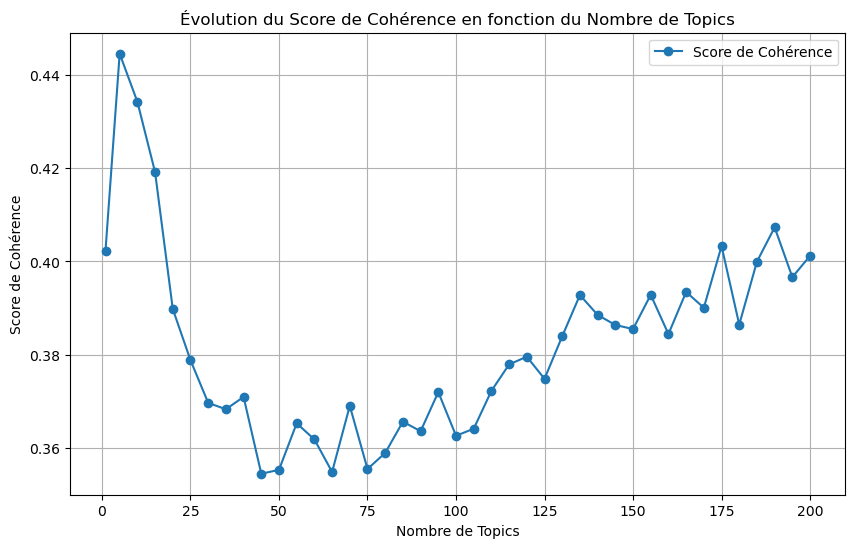

In [23]:
# Chargement des données provenant des tests réalisés (sur échantillon de 5000): 
with open('num_topics_nmf.pkl', 'rb') as fichier:
    tests_results = pickle.load(fichier)

# Réprésentation graphique des résultats : 

num_topics = list(tests_results.keys())
coherence_scores = list(tests_results.values())

# Créer un graphique à l'aide de matplotlib
plt.figure(figsize=(10, 6))  # Définir la taille du graphique (facultatif)

# Tracer la courbe des scores de cohérence
plt.plot(num_topics, coherence_scores, marker='o', linestyle='-')

# Ajouter des étiquettes et un titre
plt.xlabel('Nombre de Topics')
plt.ylabel('Score de Cohérence')
plt.title('Évolution du Score de Cohérence en fonction du Nombre de Topics')

# Afficher la légende (facultatif)
plt.legend(['Score de Cohérence'])

# Afficher le graphique
plt.grid(True)  # Activer la grille (facultatif)
plt.show()

<div class="alert alert-info">
Comme précécemment, nous devons considérer en priorité le contexte métier et les résultats de nos deux approches de proposition de tags qui vont suivre pour choisir le nombre de topics optimal.
</div>

- Entraînement du modèle NMF avec un nombre de topics optimal (contexte métier, résultats pour nos deux approches et scores de cohérence à titre indicatif et de comparaison) : 

In [24]:
num_topics_nmf = 150

debut = time.time()  # Heure de début du traitement

nmf_model = Nmf(corpus=corpus,
          id2word=id2word,
          num_topics=num_topics_nmf,
          random_state=100,
          chunksize=100, # 100
          passes=5, # 10
          kappa=1, # 1
          minimum_probability=0.01, # 0.01
          w_max_iter=300, # 200
          w_stop_condition=0.002, # 0.0001
          h_max_iter=50, # 50
          h_stop_condition=0.001, # 0.001
          normalize=True # True
)
print(f"Durée du traitement : {(time.time() - debut):.2f} s")

Durée du traitement : 9.94 s


- Calcul du score de cohérence de ce modèle : 

In [25]:
debut = time.time()  # Heure de début du traitement

coherence_model = CoherenceModel(model=nmf_model, texts=data['corpus'], dictionary=id2word, coherence='c_v')

coherence_score = coherence_model.get_coherence()

print(f"Durée du traitement : {(time.time() - debut):.2f} s")

print(f"Score de cohérence avec {nmf_model.num_topics} topics : {coherence_score:.4f}")

Durée du traitement : 14.46 s
Score de cohérence avec 150 topics : 0.3807


- Affichage des topics trouvés avec ce modèle : 

*num_words* pour choisir le nombre de mot à afficher pour chaque topic<br>
À chaque mot est associé un nombre : son importance pour le topic en question.


In [26]:
# Nombre de mots à afficher pour chaque topics
num_words = 10

topics_nmf = nmf_model.show_topics(num_topics=nmf_model.num_topics, num_words=num_words)

for topic in topics_nmf[:10]: # 10 premiers seulement
    print(topic)

(0, '0.234*"library" + 0.056*"site" + 0.051*"web" + 0.036*"link" + 0.026*"asp" + 0.020*"answer" + 0.020*"response" + 0.020*"javascript" + 0.020*"header" + 0.017*"bit"')
(1, '0.093*"repository" + 0.069*"devop" + 0.058*"azure" + 0.056*"source" + 0.050*"work" + 0.037*"pipeline" + 0.029*"git" + 0.028*"destination" + 0.026*"control" + 0.022*"store"')
(2, '0.320*"script" + 0.034*"powershell" + 0.023*"command" + 0.023*"bash" + 0.020*"warning" + 0.017*"sheet" + 0.013*"python" + 0.012*"shell" + 0.010*"run" + 0.009*"port"')
(3, '0.208*"matrix" + 0.033*"confusion" + 0.032*"position" + 0.030*"second" + 0.029*"registration" + 0.026*"element" + 0.026*"transformation" + 0.022*"rotation" + 0.021*"orientation" + 0.020*"multiplication"')
(4, '0.149*"comment" + 0.113*"post" + 0.077*"header" + 0.039*"member" + 0.035*"team" + 0.031*"implementation" + 0.030*"permission" + 0.026*"template" + 0.025*"groupid" + 0.025*"query"')
(5, '0.202*"variable" + 0.092*"spyder" + 0.085*"environment" + 0.027*"statement" + 0

### **Approche 1, avec les 5 premiers mots des topics**

In [27]:
approche1(nmf_model,
          premiers_mots=5,
          real_tags=data['tags']
)

Durée du traitement : 7.55 s

Cas avec au moins un mot en commun entre les tags réels et les tags prédits : 8.04%

Pour les 10 premiers documents : 


[['piece', 'puzzle', 'performance', 'canvas', 'context'],
 ['path', 'spyder', 'case', 'javascript', 'ssh'],
 ['code', 'python', 'compile', 'source', 'sample'],
 ['column', 'cell', 'rule', 'dataframe', 'panda'],
 ['question', 'width', 'constraint', 'border', 'status'],
 ['container', 'docker', 'host', 'terraform', 'connection'],
 ['instance', 'st', 'subnet', 'endpoint', 'vpc'],
 ['group', 'match', 'regex', 'consumer', 'topic'],
 ['number', 'bit', 'area', 'shuffle', 'location'],
 ['error', 'fix', 'help', 'resolve', 'syntax']]

### **Approche 2, avec 5 mots en commun avec le document (au maximum)**

In [28]:
approche2(nmf_model,
          taille_topic=50,
          max_mots_communs=5,
          real_tags=data['tags']
)

Durée du traitement : 10.39 s

Pourcentage de listes vides : 0.00%

Cas avec au moins un mot en commun entre les tags réels et les tags prédits : 12.48%

Pour les 10 premiers documents : 


[['piece', 'puzzle', 'performance', 'canvas', 'context'],
 ['path', 'javascript'],
 ['variable', 'setting'],
 ['column', 'dataframe', 'name', 'information', 'way'],
 ['question', 'width', 'constraint', 'border', 'project'],
 ['container', 'docker', 'host', 'subscription', 'hub'],
 ['instance', 'file', 'flag', 'space', 'replace'],
 ['group', 'sum'],
 ['number', 'help', 'javascript'],
 ['error']]

### **B). Avec corpus en BoW TF-IDF**

In [29]:
# Ce nombre de topics permet d'apporter les meilleurs résultats à nos approches
num_topics_nmf_tfid = 131

debut = time.time()  # Heure de début du traitement

nmf_model_tfid = Nmf(corpus=tfid_corpus,
          id2word=id2word,
          num_topics=num_topics_nmf_tfid,
          random_state=100,
          chunksize=100, # 100
          passes=5, # 10
          kappa=1, # 1
          minimum_probability=0.01, # 0.01
          w_max_iter=300, # 200
          w_stop_condition=0.0002, # 0.0001
          h_max_iter=100, # 50
          h_stop_condition=0.00001, # 0.001
          normalize=True # True
)
print(f"Durée du traitement : {(time.time() - debut):.2f} s")

Durée du traitement : 13.86 s


- Calcul du score de cohérence de ce modèle : 

In [30]:
debut = time.time()  # Heure de début du traitement

coherence_model = CoherenceModel(model=nmf_model_tfid, texts=data['corpus'], dictionary=id2word, coherence='c_v')

coherence_score = coherence_model.get_coherence()

print(f"Durée du traitement : {(time.time() - debut):.2f} s")

print(f"Score de cohérence avec {nmf_model_tfid.num_topics} topics : {coherence_score:.4f}")

Durée du traitement : 14.35 s
Score de cohérence avec 131 topics : 0.3953


- Affichage des topics trouvés avec ce modèle : 

*num_words* pour choisir le nombre de mot à afficher pour chaque topic<br>
À chaque mot est associé un nombre : son importance pour le topic en question.

In [31]:
# Nombre de mots à afficher pour chaque topics
num_words = 10

topics_nmf_tfid = nmf_model_tfid.show_topics(num_topics=nmf_model_tfid.num_topics, num_words=num_words)

for topic in topics_nmf_tfid[:10]: # 10 premiers seulement
    print(topic)

(0, '0.246*"name" + 0.060*"icon" + 0.055*"color" + 0.020*"link" + 0.018*"localhost" + 0.017*"tab" + 0.014*"extension" + 0.012*"category" + 0.012*"change" + 0.010*"theme"')
(1, '0.175*"process" + 0.040*"parse" + 0.029*"print" + 0.023*"ffmpeg" + 0.021*"exit" + 0.015*"powershell" + 0.013*"statement" + 0.013*"stream" + 0.012*"call" + 0.012*"pipe"')
(2, '0.166*"io" + 0.080*"flutter" + 0.037*"core" + 0.033*"install" + 0.031*"app" + 0.028*"simulator" + 0.025*"device" + 0.020*"pod" + 0.020*"console" + 0.016*"android"')
(3, '0.360*"list" + 0.051*"item" + 0.027*"index" + 0.015*"search" + 0.014*"order" + 0.014*"sort" + 0.012*"comprehension" + 0.012*"int" + 0.011*"tuple" + 0.010*"python"')
(4, '0.415*"string" + 0.017*"split" + 0.013*"regex" + 0.013*"comma" + 0.013*"format" + 0.012*"parse" + 0.012*"extract" + 0.010*"convert" + 0.009*"way" + 0.008*"char"')
(5, '0.133*"year" + 0.085*"video" + 0.058*"day" + 0.053*"month" + 0.047*"frame" + 0.031*"display" + 0.028*"regex" + 0.015*"count" + 0.015*"result

### **Approche 1, avec les 5 premiers mots des topics**

In [32]:
approche1(nmf_model_tfid,
          premiers_mots=5,
          real_tags=data['tags']
)

Durée du traitement : 7.30 s

Cas avec au moins un mot en commun entre les tags réels et les tags prédits : 10.36%

Pour les 10 premiers documents : 


[['job', 'canvas', 'performance', 'piece', 'scale'],
 ['path', 'feature', 'mapping', 'javascript', 'case'],
 ['type', 'typescript', 'union', 'definition', 'generic'],
 ['column', 'dataframe', 'frame', 'panda', 'name'],
 ['solution', 'problem', 'hour', 'issue', 'connection'],
 ['image', 'upload', 'png', 'card', 'camera'],
 ['instance', 'replace', 'flag', 'space', 'graph'],
 ['group', 'sum', 'dataframe', 'case', 'cluster'],
 ['table', 'statement', 'record', 'join', 'int'],
 ['error', 'message', 'fix', 'issue', 'code']]

### **Approche 2, avec 5 mots en commun avec le document (au maximum)**

In [33]:
approche2(nmf_model_tfid,
          taille_topic=50,
          max_mots_communs=5,
          real_tags=data['tags']
)

Durée du traitement : 10.75 s

Pourcentage de listes vides : 0.00%

Cas avec au moins un mot en commun entre les tags réels et les tags prédits : 14.32%

Pour les 10 premiers documents : 


[['canvas', 'performance', 'piece', 'scale', 'game'],
 ['path', 'feature', 'mapping', 'javascript'],
 ['name', 'extension', 'info'],
 ['column', 'dataframe', 'name', 'pyspark', 'way'],
 ['extension', 'constraint', 'width', 'text', 'solution'],
 ['host', 'need', 'reason', 'subscription', 'manager'],
 ['instance', 'replace', 'flag', 'space', 'content'],
 ['group', 'sum', 'dict'],
 ['number', 'javascript', 'problem', 'help', 'interest'],
 ['error']]

## **Meilleur modèle**

|            |LDA       |LDA (TF-IDF)|NMF     |NMF (TF-IDF)|
|---         |---       |---         |---     |---         |
|Fit time    |225.76 s  |148.39 s    |147.17 s|**135.75 s**|
|n topics    |100       |56          |150     |131         |
|Cohérence   |0.5944    |**0.6311**  |0.4188  |0.4202      |
|Approche 1  |5.70 %    |0.42 %      |10.43 % |**11.02 %** |
|Approche 2  |5.07 %    |3.46 %      |12.46 % |**12.83%**  |

**Les meilleurs résultats, en terme de correspondance entre les tags prédits et les tags réels, sont obtenus avec le modèle NMF utilisé avec un corpus vectorisé avec TF-IDF.**

## **Conclusion**

- Mesure de la durée d'exécution du notebook : 

In [34]:
temps_secondes = time.time() - t_notebook

# Conversion en minutes et secondes
minutes = int(temps_secondes // 60)
seconds = int(temps_secondes % 60)

# Formatage du résultat
formatted_time = f"{minutes:02}:{seconds:02}"

print(f"Durée d'exécution du notebook (hors imports) : {formatted_time}")

Durée d'exécution du notebook (hors imports) : 02:44
